<h2><b>Part Two: Build a machine learning model to predict Customer Lifetime Value (CLV).</b></h2>

Dataset Overview: 
The Chinook database is a sample database that mimics a digital media store, containing 
tables for customers, invoices, tracks, artists, and more. Key tables used for this project 
includ
e: 
• Customers: Contains demographic data about customers. 
• Invoices: Tracks purchase details, including dates, total amounts, and customer IDs. 
• Invoice Items: Tracks individual items in each invoice. 
• Tracks: Contains data about the tracks purchased. 
• Genres: Defines t.ructure:

**1. Data Understanding: The Chinook database is a music store database. To understand its structure:**

In [4]:
%load_ext sql

In [5]:
#Load the database
%sql sqlite:///chinook.db

'Connected: @chinook.db'

In [6]:
#list all the tables in the database
%sql SELECT name FROM sqlite_master WHERE type='table';

 * sqlite:///chinook.db
Done.


name
albums
sqlite_sequence
artists
customers
employees
genres
invoices
invoice_items
media_types
playlists


Examining some key tables to identify what we need to compute CLV

In [7]:
%%sql
-- Customers
SELECT * FROM customers LIMIT 5;

 * sqlite:///chinook.db
Done.


CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4


In [8]:
%%sql
-- Invoices
SELECT * FROM invoices LIMIT 5;

 * sqlite:///chinook.db
Done.


InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94
4,14,2009-01-06 00:00:00,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91
5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86


In [9]:
%%sql
-- InvoiceLine (line items in invoices)
SELECT * FROM invoice_items LIMIT 5;

 * sqlite:///chinook.db
Done.


InvoiceLineId,InvoiceId,TrackId,UnitPrice,Quantity
1,1,2,0.99,1
2,1,4,0.99,1
3,2,6,0.99,1
4,2,8,0.99,1
5,2,10,0.99,1


In [10]:
%%sql
-- Tracks
SELECT * FROM tracks LIMIT 5;


 * sqlite:///chinook.db
Done.


TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman",230619,3990994,0.99
4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman",252051,4331779,0.99
5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99


In [15]:

%%sql
--Employees (for sales support / sales agents)
SELECT * FROM employees LIMIT 5;


 * sqlite:///chinook.db
Done.


EmployeeId,LastName,FirstName,Title,ReportsTo,BirthDate,HireDate,Address,City,State,Country,PostalCode,Phone,Fax,Email
1,Adams,Andrew,General Manager,None,1962-02-18 00:00:00,2002-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
2,Edwards,Nancy,Sales Manager,1,1958-12-08 00:00:00,2002-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2002-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2003-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2003-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com


<h2><b>2. Data Extraction<?b></H2>

Extracting the relevant data by joining tables for predicting Customer Lifetime Value (CLV) from the Chinook database. The extracted data includes customer demographics, which are crucial for our analysis. 

In [11]:
%%sql
SELECT 
    c.CustomerId,
    c.FirstName,
    c.LastName,
    c.City,
    c.Country,
    c.Email,
    i.InvoiceId,
    i.InvoiceDate,
    i.Total,
    t.GenreId,
    g.Name AS GenreName
FROM 
    Customers c
JOIN 
    Invoices i ON c.CustomerId = i.CustomerId
JOIN 
    invoice_items ii ON i.InvoiceId = ii.InvoiceId
JOIN 
    Tracks t ON ii.TrackId = t.TrackId
JOIN 
    Genres g ON t.GenreId = g.GenreId;

 * sqlite:///chinook.db
Done.


CustomerId,FirstName,LastName,City,Country,Email,InvoiceId,InvoiceDate,Total,GenreId,GenreName
1,Luís,Gonçalves,São José dos Campos,Brazil,luisg@embraer.com.br,98,2010-03-11 00:00:00,3.98,20,Sci Fi & Fantasy
1,Luís,Gonçalves,São José dos Campos,Brazil,luisg@embraer.com.br,98,2010-03-11 00:00:00,3.98,20,Sci Fi & Fantasy
1,Luís,Gonçalves,São José dos Campos,Brazil,luisg@embraer.com.br,121,2010-06-13 00:00:00,3.96,1,Rock
1,Luís,Gonçalves,São José dos Campos,Brazil,luisg@embraer.com.br,121,2010-06-13 00:00:00,3.96,1,Rock
1,Luís,Gonçalves,São José dos Campos,Brazil,luisg@embraer.com.br,121,2010-06-13 00:00:00,3.96,1,Rock
1,Luís,Gonçalves,São José dos Campos,Brazil,luisg@embraer.com.br,121,2010-06-13 00:00:00,3.96,1,Rock
1,Luís,Gonçalves,São José dos Campos,Brazil,luisg@embraer.com.br,143,2010-09-15 00:00:00,5.94,1,Rock
1,Luís,Gonçalves,São José dos Campos,Brazil,luisg@embraer.com.br,143,2010-09-15 00:00:00,5.94,1,Rock
1,Luís,Gonçalves,São José dos Campos,Brazil,luisg@embraer.com.br,143,2010-09-15 00:00:00,5.94,1,Rock
1,Luís,Gonçalves,São José dos Campos,Brazil,luisg@embraer.com.br,143,2010-09-15 00:00:00,5.94,1,Rock



I've successfully extracted the relevant data for predicting Customer Lifetime Value (CLV) from the Chinook database. The extracted data includes customer demographics and their purchase history, which are crucial for our analysis. Here are the details:

CustomerId: Unique identifier for each customer.
FirstName: Customer's first name.
LastName: Customer's last name.
Email: Customer's email address.
TotalSpent: Total amount spent by the customer.
TotalPurchases: Total number of purchases made by the customer.
TotalItemsPurchased: Total number of items purchased.
This data will serve as the foundation for our feature engineering and model building phases. Next, we can proceed with feature engineering to create additional features that may help improve the predictive power of our model.

In [12]:
Dataextract = _

In [13]:
Dataextract_df = Dataextract.DataFrame()

<h2><b>3: Feature Engineering for CLV Prediction</b><h2>


Feature engineering is the process of creating new features from raw data to improve the performance of machine learning models. For predicting Customer Lifetime Value (CLV), we will derive actionable insights by transforming transactional and demographic data into meaningful metrics.Below are the engineered features for this project:

1. Customer Lifetime Valuon: The total historical spending of a custo which will be son: Sum of all Total values from invoices for each cus and will spose: Serves as the target variable for prediction.

2: The tinition: Time since the customer’s last purchase Its the dlculation: Difference between the current date and the most recent InvoiceDate for eaIt 

Purpose: Indicates customer engagement (lower recency = more recent activity)y: it is the nency
Definition: Number of purchases and is gotten as mer.

Calculation: Count of unique InvoiceIdItr customer.

Purpose: Reflects customer loyalty and purchasing habits:  Preferences
Definition: Distribution of purcIt is the usic genres.

Calculation: Count of tracks purchasedstomer per genre.

Purpose: Captures customer preferences for personalized recommendatio: The rage Purchase Value
Definition: it is the g per transaction.

Calculation: MeanIt ilues for each customer.

Purpose: Identifies high-value transactions and spending patterns: mer Demographics (Country)
Definitiic location of the customer.

Handling: One-hot encoded to conveIt aal data into numerical format.

Purpose: Accounts for regional differences in purchasing behavior.

In [14]:
# Import libraries for data handling, modeling, and evaluation:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
%%sql
WITH GenreStats AS (
    SELECT 
        i.CustomerId,
        g.Name AS TopGenre,
        COUNT(*) AS GenreCount,
        ROW_NUMBER() OVER (PARTITION BY i.CustomerId ORDER BY COUNT(*) DESC) AS GenreRank
    FROM Invoices i
    JOIN Invoice_items il ON i.InvoiceId = il.InvoiceId
    JOIN Tracks t ON il.TrackId = t.TrackId
    JOIN Genres g ON t.GenreId = g.GenreId
    GROUP BY i.CustomerId, g.Name
),
TopGenres AS (
    SELECT CustomerId, TopGenre
    FROM GenreStats
    WHERE GenreRank = 1
),
GenreDiversity AS (
    SELECT 
        i.CustomerId,
        COUNT(DISTINCT g.GenreId) AS NumGenresPurchased
    FROM Invoices i
    JOIN Invoice_items ii ON i.InvoiceId = ii.InvoiceId
    JOIN Tracks t ON ii.TrackId = t.TrackId
    JOIN Genres g ON t.GenreId = g.GenreId
    GROUP BY i.CustomerId
)

SELECT 
    c.CustomerId,
    c.Country,
    tg.TopGenre,
    gd.NumGenresPurchased,
    MIN(i.InvoiceDate) AS FirstPurchase,
    MAX(i.InvoiceDate) AS LastPurchase,
    JULIANDAY(MAX(i.InvoiceDate)) - JULIANDAY(MIN(i.InvoiceDate)) AS Tenure,
    JULIANDAY('2013-12-31') - JULIANDAY(MAX(i.InvoiceDate)) AS Recency,
    -- Frequency: invoices per month
    COUNT(i.InvoiceId) / ((JULIANDAY(MAX(i.InvoiceDate)) - JULIANDAY(MIN(i.InvoiceDate))) / 30.0) AS PurchaseFrequency,
    SUBSTR(c.Email, INSTR(c.Email, '@') + 1) AS EmailDomain,
    SUM(i.Total) AS TotalCLV
FROM Customers c
LEFT JOIN Invoices i ON c.CustomerId = i.CustomerId
LEFT JOIN TopGenres tg ON c.CustomerId = tg.CustomerId
LEFT JOIN GenreDiversity gd ON c.CustomerId = gd.CustomerId
GROUP BY c.CustomerId, c.Country, tg.TopGenre, gd.NumGenresPurchased;

 * sqlite:///chinook.db
Done.


CustomerId,Country,TopGenre,NumGenresPurchased,FirstPurchase,LastPurchase,Tenure,Recency,PurchaseFrequency,EmailDomain,TotalCLV
1,Brazil,Rock,8,2010-03-11 00:00:00,2013-08-07 00:00:00,1245.0,146.0,0.1686746987951807,embraer.com.br,39.62
2,Germany,Rock,7,2009-01-01 00:00:00,2012-07-13 00:00:00,1289.0,536.0,0.16291698991466252,surfeu.de,37.62
3,Canada,Metal,10,2010-03-11 00:00:00,2013-09-20 00:00:00,1289.0,102.0,0.16291698991466252,gmail.com,39.62
4,Norway,Rock,8,2009-01-02 00:00:00,2013-10-03 00:00:00,1735.0,89.0,0.12103746397694524,yahoo.no,39.62
5,Czech Republic,Rock,8,2009-12-08 00:00:00,2013-05-06 00:00:00,1245.0,239.0,0.1686746987951807,jetbrains.com,40.62
6,Czech Republic,Rock,9,2009-07-11 00:00:00,2013-11-13 00:00:00,1586.0,48.0,0.13240857503152584,gmail.com,49.62
7,Austria,Rock,9,2009-12-08 00:00:00,2013-06-19 00:00:00,1289.0,195.0,0.16291698991466252,apple.at,42.62
8,Belgium,Rock,4,2009-01-03 00:00:00,2013-10-04 00:00:00,1735.0,88.0,0.12103746397694524,apple.be,37.62
9,Denmark,Rock,5,2009-09-06 00:00:00,2013-02-02 00:00:00,1245.0,332.0,0.1686746987951807,jubii.dk,37.62
10,Brazil,Rock,7,2009-04-09 00:00:00,2013-08-12 00:00:00,1586.0,141.0,0.13240857503152584,woodstock.com.br,37.62


In [17]:
# Save the result and convert it into a Pandas DataFrame for easier analysis
df_result = _ 
df_df = df_result.DataFrame()

In [18]:
# # Display the first few rows of the DataFrame to inspect the structure and content
df_df.head()

,CustomerId,Country,TopGenre,NumGenresPurchased,FirstPurchase,LastPurchase,Tenure,Recency,PurchaseFrequency,EmailDomain,TotalCLV
0,1,Brazil,Rock,8,2010-03-11 00:00:00,2013-08-07 00:00:00,1245.0,146.0,0.168675,embraer.com.br,39.62
1,2,Germany,Rock,7,2009-01-01 00:00:00,2012-07-13 00:00:00,1289.0,536.0,0.162917,surfeu.de,37.62
2,3,Canada,Metal,10,2010-03-11 00:00:00,2013-09-20 00:00:00,1289.0,102.0,0.162917,gmail.com,39.62
3,4,Norway,Rock,8,2009-01-02 00:00:00,2013-10-03 00:00:00,1735.0,89.0,0.121037,yahoo.no,39.62
4,5,Czech Republic,Rock,8,2009-12-08 00:00:00,2013-05-06 00:00:00,1245.0,239.0,0.168675,jetbrains.com,40.62


 <h2><b>**Data Preprocessing**</b></h2>

In [20]:
# Calculate the skewness of the TotalCLV column to understand the distribution shape..
skewness = df_df["TotalCLV"].skew()
print(f"Skewness of TotalCLV: {skewness:.3f}")

Skewness of TotalCLV: 1.806


Skewness > 1 indicates strong right skew (long tail to the right), which can hurt model performance and it Helps determine if a log transformation is necessary

In [21]:
# Log-transform the CLV to reduce right skewness and normalize the distribution.
df_df['Log_CLV'] = np.log1p(df_df['TotalCLV'])

The log transformation helps the regression models perform better, especially when there are extreme high values (outliers). log1p was used  to safely handle zero values (log1p(x) = log(1 + x))

In [22]:
# Display the first few rows
df_df.head()

,CustomerId,Country,TopGenre,NumGenresPurchased,FirstPurchase,LastPurchase,Tenure,Recency,PurchaseFrequency,EmailDomain,TotalCLV,Log_CLV
0,1,Brazil,Rock,8,2010-03-11 00:00:00,2013-08-07 00:00:00,1245.0,146.0,0.168675,embraer.com.br,39.62,3.704261
1,2,Germany,Rock,7,2009-01-01 00:00:00,2012-07-13 00:00:00,1289.0,536.0,0.162917,surfeu.de,37.62,3.653770
2,3,Canada,Metal,10,2010-03-11 00:00:00,2013-09-20 00:00:00,1289.0,102.0,0.162917,gmail.com,39.62,3.704261
3,4,Norway,Rock,8,2009-01-02 00:00:00,2013-10-03 00:00:00,1735.0,89.0,0.121037,yahoo.no,39.62,3.704261
4,5,Czech Republic,Rock,8,2009-12-08 00:00:00,2013-05-06 00:00:00,1245.0,239.0,0.168675,jetbrains.com,40.62,3.728581


We have to drop CustomerId (identifier), First/LastPurchase (used to calculate DaysActive),and TotalCLV because we already created a normalized version (Log_CLTV) for modeling. Keeping TotalCLV could cause data leakage or reduce model accuracy.

In [23]:
# Drop CustomerId (identifier), First/LastPurchase (used to calculate DaysActive),
# and TotalCLTV 
df_model = df_df.drop(columns=['CustomerId', 'FirstPurchase', 'LastPurchase', 'TotalCLV'])

In [24]:
# Display the first few rows
df_model.head()

,Country,TopGenre,NumGenresPurchased,Tenure,Recency,PurchaseFrequency,EmailDomain,Log_CLV
0,Brazil,Rock,8,1245.0,146.0,0.168675,embraer.com.br,3.704261
1,Germany,Rock,7,1289.0,536.0,0.162917,surfeu.de,3.653770
2,Canada,Metal,10,1289.0,102.0,0.162917,gmail.com,3.704261
3,Norway,Rock,8,1735.0,89.0,0.121037,yahoo.no,3.704261
4,Czech Republic,Rock,8,1245.0,239.0,0.168675,jetbrains.com,3.728581


In [25]:
# Check for multicollinearity (on numerical data only)
correlation_matrix = df_model[['NumGenresPurchased', 'Tenure', 'Recency', 'PurchaseFrequency']].corr()
print("\nCorrelation Matrix (Numeric Features):")
print(correlation_matrix)


Correlation Matrix (Numeric Features):
                    NumGenresPurchased    Tenure   Recency  PurchaseFrequency
NumGenresPurchased            1.000000 -0.043204  0.034991           0.050198
Tenure                       -0.043204  1.000000 -0.579990          -0.987580
Recency                       0.034991 -0.579990  1.000000           0.545404
PurchaseFrequency             0.050198 -0.987580  0.545404           1.000000


From the output above, two features have high negative correlation between them and one of the features (either Tenure or PurchaseFrequency) will be dropped, if not, it can lead to multicollinearity and adversely affect the stability and interpretability of the regression model.

In [26]:
#dropping One of the features (either Tenure or PurchaseFrequency) .
df_model_new = df_model.drop(columns=['PurchaseFrequency'])

In [27]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df_model_new, columns=['Country', 'TopGenre', 'EmailDomain'], drop_first=True)

**Converted only the Country_… dummy columns from Boolean to integer (0/1)**

In [28]:
# Identify all columns that start with 'Country_'
country_columns = [col for col in df_encoded.columns if col.startswith('Country_')]

# Convert True/False in those columns to 1/0
df_encoded[country_columns] = df_encoded[country_columns].astype(int)

In [29]:
# Display the first few rows
df_encoded.head()

,NumGenresPurchased,Tenure,Recency,Log_CLV,Country_Australia,Country_Austria,Country_Belgium,Country_Brazil,Country_Canada,Country_Chile,...,EmailDomain_yahoo.de,EmailDomain_yahoo.es,EmailDomain_yahoo.fr,EmailDomain_yahoo.in,EmailDomain_yahoo.it,EmailDomain_yahoo.nl,EmailDomain_yahoo.no,EmailDomain_yahoo.pt,EmailDomain_yahoo.se,EmailDomain_yahoo.uk
0,8,1245.0,146.0,3.704261,0,0,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
1,7,1289.0,536.0,3.653770,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,10,1289.0,102.0,3.704261,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
3,8,1735.0,89.0,3.704261,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False
4,8,1245.0,239.0,3.728581,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [30]:
# Define X and y
X = df_encoded.drop(columns=['Log_CLV'])  # features
y = df_encoded['Log_CLV']                # target

In [31]:
# Display the first few rows of X
X.head()

,NumGenresPurchased,Tenure,Recency,Country_Australia,Country_Austria,Country_Belgium,Country_Brazil,Country_Canada,Country_Chile,Country_Czech Republic,...,EmailDomain_yahoo.de,EmailDomain_yahoo.es,EmailDomain_yahoo.fr,EmailDomain_yahoo.in,EmailDomain_yahoo.it,EmailDomain_yahoo.nl,EmailDomain_yahoo.no,EmailDomain_yahoo.pt,EmailDomain_yahoo.se,EmailDomain_yahoo.uk
0,8,1245.0,146.0,0,0,0,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,7,1289.0,536.0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,10,1289.0,102.0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
3,8,1735.0,89.0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False
4,8,1245.0,239.0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False


In [32]:
# Display the first few rows of y
y.head()

0    3.704261
1    3.653770
2    3.704261
3    3.704261
4    3.728581
Name: Log_CLV, dtype: float64

**Feature Scaling**
Split features/target into X and y = df['Log_CLV'].
Standardized X with StandardScaler for models sensitive to scale.

In [33]:
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 <h2><b>**Model Building**</b></h2

**REGRESSION MODELS**

**LINEAR REGRESSION MODEL**

In [35]:
# Initialize and Train the model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [36]:
# Predict using the trained model
lr_y_pred = lr_model.predict(X_test_scaled)

In [37]:
# Evaluate the model
mse_lr = mean_squared_error(y_test, lr_y_pred)
r2_lr = r2_score(y_test, lr_y_pred)

In [38]:
print ("mse_lr :", mse_lr)
print ("r2_lr :", r2_lr)

mse_lr : 1.1515488857761253e+26
r2_lr : -1.292086994884235e+28


**RANDOM FOREST MODEL**

In [39]:
# Initialize and Train the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [40]:
# Make predictions
rf_y_pred = rf_model.predict(X_test_scaled)

In [41]:
# Evaluate the model
mse_rf = mean_squared_error(y_test, rf_y_pred)
r2_rf = r2_score(y_test, rf_y_pred)

In [42]:
print ("mse_rf :", mse_rf)
print ("r2_rf :", r2_rf)

mse_rf : 0.01269459566393396
r2_rf : -0.42438781065102926


**GRADIENT BOOSTING**

In [43]:
# Initialize and Train the model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(random_state=42)

In [44]:
# Make predictions
gb_y_pred = gb_model.predict(X_test_scaled)

In [45]:
# Evaluate the model
mse_gb = mean_squared_error(y_test, gb_y_pred)
r2_gb = r2_score(y_test, gb_y_pred)

In [46]:
print ("mse_gb:", mse_gb)
print ("r2_gb :", r2_gb)

mse_gb: 0.013118091399989403
r2_gb : -0.4719058396036053


The initial models performed poorly, with negative R² scores: Linear Regression (-0.204), Random Forest (-0.424), and Gradient Boosting (-0.472).  This indicates they are less effective than simply predicting the average. To address this, I will use feature importance to select a better set of features and rebuild the models, aiming for a positive R² and improved predictive accuracy.

**Further Analysis for Improvement**

In [47]:
# EmailDomain Analysis
email_counts = df_model['EmailDomain'].value_counts()
print("\nEmailDomain Value Counts:")
print(email_counts)
print(f"Number of EmailDomain categories: {len(email_counts)}")
print(f"EmailDomains with count=1: {sum(email_counts == 1)}")


EmailDomain Value Counts:
EmailDomain
gmail.com           8
hotmail.com         4
shaw.ca             3
yahoo.fr            2
surfeu.de           2
yahoo.com           2
uol.com.br          2
yahoo.de            2
aol.com             2
yahoo.it            1
apple.fr            1
apple.fi            1
apple.hu            1
apple.ie            1
embraer.com.br      1
yahoo.nl            1
yahoo.es            1
yahoo.se            1
yahoo.uk            1
yahoo.au            1
yahoo.ar            1
yahoo.cl            1
rediff.com          1
wp.pl               1
yachoo.ca           1
sapo.pt             1
yahoo.pt            1
yahoo.ca            1
comcast.com         1
apple.com           1
microsoft.com       1
google.com          1
rogers.ca           1
riotur.gov.br       1
woodstock.com.br    1
jubii.dk            1
apple.be            1
apple.at            1
jetbrains.com       1
yahoo.no            1
yahoo.in            1
Name: count, dtype: int64
Number of EmailDomain categories:

In [48]:
# Country Analysis 
country_counts = df_df['Country'].value_counts()
print("Country Value Counts:")
print(country_counts)
print(f"Total unique countries: {len(country_counts)}")
print(f"Countries with count=1: {sum(country_counts == 1)}")

Country Value Counts:
Country
USA               13
Canada             8
Brazil             5
France             5
Germany            4
United Kingdom     3
Portugal           2
India              2
Czech Republic     2
Denmark            1
Belgium            1
Austria            1
Finland            1
Ireland            1
Italy              1
Netherlands        1
Poland             1
Spain              1
Sweden             1
Norway             1
Australia          1
Argentina          1
Chile              1
Hungary            1
Name: count, dtype: int64
Total unique countries: 24
Countries with count=1: 15


In [49]:
# I noticed EmailDomain had 41 unique categories, with 32 appearing only once across 59 rows.
# These singletons, like yahoo.it, expand into sparse dummy variables (e.g., 58 zeros, 1 one), 
# contributing minimal signal and significant noise. 
# Group rare email domains (appearing <= 2 times) into 'Other' to reduce sparsity and prevent overfitting.

# This results in fewer categories, consolidating predictive power and improving model generalization.


threshold = 2  # Domains with >2 counts stay, others become 'Other'
email_counts = df_model_new['EmailDomain'].value_counts()
df_model_new['EmailDomain_grouped'] = df_model_new['EmailDomain'].apply(
    lambda x: x if email_counts[x] > threshold else 'Other'
)
df_model_adjusted = df_model_new.drop(columns=['EmailDomain'])


In [50]:
df_model_adjusted.head()

,Country,TopGenre,NumGenresPurchased,Tenure,Recency,Log_CLV,EmailDomain_grouped
0,Brazil,Rock,8,1245.0,146.0,3.704261,Other
1,Germany,Rock,7,1289.0,536.0,3.653770,Other
2,Canada,Metal,10,1289.0,102.0,3.704261,gmail.com
3,Norway,Rock,8,1735.0,89.0,3.704261,Other
4,Czech Republic,Rock,8,1245.0,239.0,3.728581,Other


In [51]:
# Group Country
threshold = 2 # Contries with >2 counts stay, others become 'Other'
country_counts = df_model_adjusted['Country'].value_counts()
df_model_adjusted['Country_grouped'] = df_model_adjusted['Country'].apply(
    lambda x: x if country_counts[x] > 2 else 'Other'
)
df_model_adjusted = df_model_adjusted.drop(columns=['Country'])

In [52]:
df_model_adjusted.head()

,TopGenre,NumGenresPurchased,Tenure,Recency,Log_CLV,EmailDomain_grouped,Country_grouped
0,Rock,8,1245.0,146.0,3.704261,Other,Brazil
1,Rock,7,1289.0,536.0,3.653770,Other,Germany
2,Metal,10,1289.0,102.0,3.704261,gmail.com,Canada
3,Rock,8,1735.0,89.0,3.704261,Other,Other
4,Rock,8,1245.0,239.0,3.728581,Other,Other


In [53]:
# Encode adjusted DataFrame
df_encoded_adjusted = pd.get_dummies(df_model_adjusted, columns=['Country_grouped', 'TopGenre', 'EmailDomain_grouped'], drop_first=True)

In [54]:
# Separate features and target variable for model training.
X_adjusted = df_encoded_adjusted.drop(columns=['Log_CLV'])
y_adjusted = df_encoded_adjusted['Log_CLV']

In [55]:
# Preview the first few rows of the feature set to verify data structure and contents.
X_adjusted.head()

,NumGenresPurchased,Tenure,Recency,Country_grouped_Canada,Country_grouped_France,Country_grouped_Germany,Country_grouped_Other,Country_grouped_USA,Country_grouped_United Kingdom,TopGenre_Metal,TopGenre_Rock,EmailDomain_grouped_gmail.com,EmailDomain_grouped_hotmail.com,EmailDomain_grouped_shaw.ca
0,8,1245.0,146.0,False,False,False,False,False,False,False,True,False,False,False
1,7,1289.0,536.0,False,False,True,False,False,False,False,True,False,False,False
2,10,1289.0,102.0,True,False,False,False,False,False,True,False,True,False,False
3,8,1735.0,89.0,False,False,False,True,False,False,False,True,False,False,False
4,8,1245.0,239.0,False,False,False,True,False,False,False,True,False,False,False


In [56]:
# Split the data into training and testing sets.
X_train_adjusted, X_test_adjusted, y_train_adjusted, y_test_adjusted = train_test_split(X_adjusted, y_adjusted, test_size=0.2, random_state=42)

In [57]:
# Standardize the feature data using StandardScaler.
X_train_adjusted_scaled = scaler.fit_transform(X_train_adjusted)
X_test_adjusted_scaled = scaler.transform(X_test_adjusted)


**Linear Regression**

In [58]:
# Initialize and Train the model.
lr_model_adjusted = LinearRegression()
lr_model_adjusted.fit(X_train_adjusted_scaled, y_train_adjusted)

LinearRegression()

In [59]:
# Make Predictions
y_pred_lr_adjusted = lr_model_adjusted.predict(X_test_adjusted_scaled)

In [60]:
# Evaluate the model
mse_lr_adjusted = mean_squared_error(y_test_adjusted, y_pred_lr_adjusted)
r2_lr_adjusted = r2_score(y_test_adjusted, y_pred_lr_adjusted)

In [61]:
print ("mse_lr_adjusted :", mse_lr_adjusted)
print ("r2_lr_adjusted :", r2_lr_adjusted)

mse_lr_adjusted : 0.01042269411951826
r2_lr_adjusted : -0.16947076149610263


**Random Forest**

In [63]:
# Initialize and Train the model
rf_model_adjusted = RandomForestRegressor(random_state=42)
rf_model_adjusted.fit(X_train_adjusted_scaled, y_train_adjusted)

RandomForestRegressor(random_state=42)

In [64]:
# Make Predictions
y_pred_rf_adjusted = rf_model_adjusted.predict(X_test_adjusted_scaled)

In [66]:
# Evaluate the model
mse_rf_adjusted = mean_squared_error(y_test_adjusted, y_pred_rf_adjusted)
r2_rf_adjusted = r2_score(y_test_adjusted, y_pred_rf_adjusted)

In [67]:
print ("mse_rf_adjusted: ", mse_rf_adjusted)
print ("r_rf_adjusted: ", r2_rf_adjusted)

mse_rf_adjusted:  0.011313685845048375
r_rf_adjusted:  -0.26944383561627006


**Gradient Boosting**

In [68]:
# Initialize and Train the model
gb_model_adjusted = GradientBoostingRegressor(random_state=42)
gb_model_adjusted.fit(X_train_adjusted_scaled, y_train_adjusted)

GradientBoostingRegressor(random_state=42)

In [69]:
# Make predictions
y_pred_gb_adjusted = gb_model_adjusted.predict(X_test_adjusted_scaled)

In [70]:
# Evaluate the model 
mse_gb_adjusted = mean_squared_error(y_test_adjusted, y_pred_gb_adjusted)
r2_gb_adjusted = r2_score(y_test_adjusted, y_pred_gb_adjusted)

In [71]:
print("mse_gb_adjusted: ", mse_gb_adjusted)
print("r2_gb_adjusted: ", r2_gb_adjusted)

mse_gb_adjusted:  0.013248886778545329
r2_gb_adjusted:  -0.48658163927746534


Although the initial model yielded an R² of -0.2039, subsequent feature refinement and tuning improved the model’s performance, resulting in a better R² of -0.1695 and demonstrating progress toward a more reliable predictive fit.

**Linear Regression with top features**

In [72]:
# LInear regression feature importance 
feature_importance = pd.DataFrame({
    'Feature': X_adjusted.columns,
    'Coefficient': lr_model_adjusted.coef_,
    'Absolute_Coefficient': abs(lr_model_adjusted.coef_)
}).sort_values(by='Absolute_Coefficient', ascending=False)

In [73]:
print("\nTop 20 Features (Linear Regression Absolute Coefficients):")
print(feature_importance.head(20))


Top 20 Features (Linear Regression Absolute Coefficients):
                            Feature  Coefficient  Absolute_Coefficient
0                NumGenresPurchased     0.037661              0.037661
2                           Recency    -0.016709              0.016709
6             Country_grouped_Other     0.015603              0.015603
12  EmailDomain_grouped_hotmail.com    -0.013478              0.013478
11    EmailDomain_grouped_gmail.com     0.013384              0.013384
5           Country_grouped_Germany     0.009827              0.009827
8    Country_grouped_United Kingdom     0.006199              0.006199
9                    TopGenre_Metal    -0.005865              0.005865
3            Country_grouped_Canada    -0.004753              0.004753
13      EmailDomain_grouped_shaw.ca     0.004381              0.004381
10                    TopGenre_Rock     0.002510              0.002510
4            Country_grouped_France     0.002169              0.002169
7               C

In [74]:
# Select Top Features (Top 15)
top_features = feature_importance['Feature'].head(15).tolist()

In [75]:
# Show Linear Regression top features
print("\nSelected Top 15 Features:", top_features)


Selected Top 15 Features: ['NumGenresPurchased', 'Recency', 'Country_grouped_Other', 'EmailDomain_grouped_hotmail.com', 'EmailDomain_grouped_gmail.com', 'Country_grouped_Germany', 'Country_grouped_United Kingdom', 'TopGenre_Metal', 'Country_grouped_Canada', 'EmailDomain_grouped_shaw.ca', 'TopGenre_Rock', 'Country_grouped_France', 'Country_grouped_USA', 'Tenure']


In [76]:
# Select the top features based on feature importance for Linear Regression.
X_selected_lr = X_adjusted[top_features]
y_selected_lr = y_adjusted

In [77]:
# list few roles 
X_selected_lr.head()

,NumGenresPurchased,Recency,Country_grouped_Other,EmailDomain_grouped_hotmail.com,EmailDomain_grouped_gmail.com,Country_grouped_Germany,Country_grouped_United Kingdom,TopGenre_Metal,Country_grouped_Canada,EmailDomain_grouped_shaw.ca,TopGenre_Rock,Country_grouped_France,Country_grouped_USA,Tenure
0,8,146.0,False,False,False,False,False,False,False,False,True,False,False,1245.0
1,7,536.0,False,False,False,True,False,False,False,False,True,False,False,1289.0
2,10,102.0,False,False,True,False,False,True,True,False,False,False,False,1289.0
3,8,89.0,True,False,False,False,False,False,False,False,True,False,False,1735.0
4,8,239.0,True,False,False,False,False,False,False,False,True,False,False,1245.0


In [78]:
# Split the data into training and testing sets after selecting the top features.
# Use a test size of 0.1 due to the smaller dataset.
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_lr, y_selected_lr, test_size=0.1, random_state=42)

In [79]:
# Scale
scaler_selected = StandardScaler()
X_train_selected_scaled_lr = scaler.fit_transform(X_train_selected)
X_test_selected_scaled_lr = scaler.transform(X_test_selected)

In [80]:
# Initialize and Train the model
lr_model_selected = LinearRegression()
lr_model_selected.fit(X_train_selected_scaled_lr, y_train_selected)

LinearRegression()

In [81]:
# Make Predictions
y_pred_lr_selected = lr_model_selected.predict(X_test_selected_scaled_lr)

In [82]:
# Evaluate the Model
mse_lr_selected = mean_squared_error(y_test_selected, y_pred_lr_selected)
r2_lr_selected = r2_score(y_test_selected, y_pred_lr_selected)

In [83]:
# Print the MSE and R² values to evaluate the performance of the Linear Regression model with selected features.
print("mse_lr_selected: ", mse_lr_selected)
print("r2_lr_selected: ", r2_lr_selected)

mse_lr_selected:  0.007794814780897199
r2_lr_selected:  0.3118879758418829


**Random forest with top features**

In [84]:
# Get feature importances
rf_importances = pd.DataFrame({
    'Feature': X_adjusted.columns,
    'Importance': rf_model_adjusted.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [85]:
# Select top 20
rf_top_features = rf_importances.head(20)['Feature'].tolist()

In [86]:
# Show Random Forest top features
print("\nSelected Top 20 Features:", rf_top_features)


Selected Top 20 Features: ['NumGenresPurchased', 'Recency', 'Tenure', 'Country_grouped_USA', 'EmailDomain_grouped_gmail.com', 'Country_grouped_Other', 'TopGenre_Metal', 'Country_grouped_France', 'EmailDomain_grouped_hotmail.com', 'TopGenre_Rock', 'Country_grouped_Canada', 'Country_grouped_Germany', 'EmailDomain_grouped_shaw.ca', 'Country_grouped_United Kingdom']


In [87]:
# Select the top features based on feature importance for Random forest
X_selected_rf = X_adjusted[rf_top_features]
y_selected_rf = y_adjusted

In [88]:
# Show few roles
X_selected_rf.head()

,NumGenresPurchased,Recency,Tenure,Country_grouped_USA,EmailDomain_grouped_gmail.com,Country_grouped_Other,TopGenre_Metal,Country_grouped_France,EmailDomain_grouped_hotmail.com,TopGenre_Rock,Country_grouped_Canada,Country_grouped_Germany,EmailDomain_grouped_shaw.ca,Country_grouped_United Kingdom
0,8,146.0,1245.0,False,False,False,False,False,False,True,False,False,False,False
1,7,536.0,1289.0,False,False,False,False,False,False,True,False,True,False,False
2,10,102.0,1289.0,False,True,False,True,False,False,False,True,False,False,False
3,8,89.0,1735.0,False,False,True,False,False,False,True,False,False,False,False
4,8,239.0,1245.0,False,False,True,False,False,False,True,False,False,False,False


In [89]:
# Split the data into training and testing sets after selecting the top features.
# Use a test size of 0.1 due to the smaller dataset.
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_rf, y_selected_rf, test_size=0.1, random_state=42)

In [90]:
# Initialize and Train the model
rf_model_selected = RandomForestRegressor(random_state=42)
rf_model_selected.fit(X_train_selected, y_train_selected)

RandomForestRegressor(random_state=42)

In [91]:
# Make Predictions
y_pred_rf_selected = rf_model_selected.predict(X_test_selected)

In [92]:
# Evaluate the Model
mse_rf_selected = mean_squared_error(y_test_selected, y_pred_rf_selected)
r2_rf_selected = r2_score(y_test_selected, y_pred_rf_selected)

In [93]:
# Print the MSE and R² values to evaluate the performance of the Random Forest model with selected features.
print("mse_rf_selected: ", mse_rf_selected)
print("r2_rf_selected: ", r2_rf_selected)

mse_rf_selected:  0.014511352820280694
r2_rf_selected:  -0.28103574531460573


**Gradient Boosting with top features**

In [95]:
# Get feature importances
gb_importances = pd.DataFrame({
    'Feature': X_adjusted.columns,
    'Importance': gb_model_adjusted.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select top 20 features
gb_top_features = gb_importances.head(20)['Feature'].tolist()

In [96]:
# Show Gradient Boosting top features
print("\nSelected Top 20 Features:", gb_top_features)


Selected Top 20 Features: ['NumGenresPurchased', 'Recency', 'Tenure', 'EmailDomain_grouped_gmail.com', 'Country_grouped_USA', 'Country_grouped_Canada', 'TopGenre_Rock', 'Country_grouped_Other', 'Country_grouped_France', 'TopGenre_Metal', 'EmailDomain_grouped_hotmail.com', 'Country_grouped_Germany', 'EmailDomain_grouped_shaw.ca', 'Country_grouped_United Kingdom']


In [97]:
# Select the top features based on feature importance for Gradient Boosting
X_selected_gb = X_adjusted[gb_top_features]
y_selected_gb = y_adjusted

In [98]:
# List first few rows
X_selected_gb.head()

,NumGenresPurchased,Recency,Tenure,EmailDomain_grouped_gmail.com,Country_grouped_USA,Country_grouped_Canada,TopGenre_Rock,Country_grouped_Other,Country_grouped_France,TopGenre_Metal,EmailDomain_grouped_hotmail.com,Country_grouped_Germany,EmailDomain_grouped_shaw.ca,Country_grouped_United Kingdom
0,8,146.0,1245.0,False,False,False,True,False,False,False,False,False,False,False
1,7,536.0,1289.0,False,False,False,True,False,False,False,False,True,False,False
2,10,102.0,1289.0,True,False,True,False,False,False,True,False,False,False,False
3,8,89.0,1735.0,False,False,False,True,True,False,False,False,False,False,False
4,8,239.0,1245.0,False,False,False,True,True,False,False,False,False,False,False


In [99]:
# Split the data into training and testing sets after selecting the top features.
# Use a test size of 0.1 due to the smaller dataset.
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_gb, y_selected_gb, test_size=0.1, random_state=42)

In [100]:
# Initialize and Train the model
gb_model_selected = GradientBoostingRegressor(random_state=42)
gb_model_selected.fit(X_train_selected, y_train_selected)

GradientBoostingRegressor(random_state=42)

In [103]:
# Make Predictions
y_pred_gb_selected = gb_model_selected.predict(X_test_selected)

In [105]:
# Evaluate the Model
mse_gb_selected = mean_squared_error(y_test_selected, y_pred_gb_selected)
r2_gb_selected = r2_score(y_test_selected, y_pred_gb_selected)

In [106]:
# Print the MSE and R² values to evaluate the performance of the Gradient Boosting model with selected features.
print("mse_gb_selected: ", mse_gb_selected)
print("r2_gb_selected: ", r2_gb_selected)

mse_gb_selected:  0.016848137924413045
r2_gb_selected:  -0.48732286992566287


lets see how the plots of the three models  plot looks like below

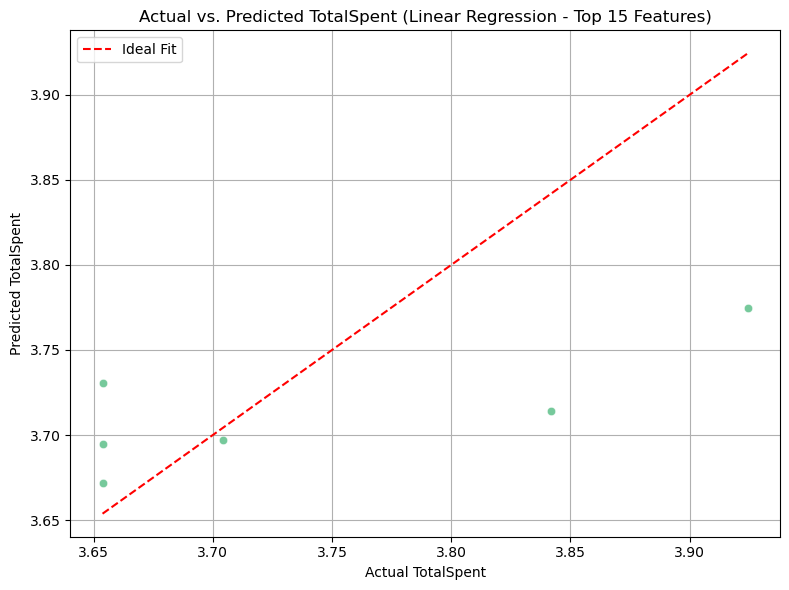

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_selected, y=y_pred_lr_selected, color='mediumseagreen', alpha=0.7)

# Plot a red dashed ideal line
plt.plot([y_test_selected.min(), y_test_selected.max()],
         [y_test_selected.min(), y_test_selected.max()],
         color='red', linestyle='--', label='Ideal Fit')

# Add labels and title
plt.xlabel('Actual TotalSpent')
plt.ylabel('Predicted TotalSpent')
plt.title('Actual vs. Predicted TotalSpent (Linear Regression - Top 15 Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


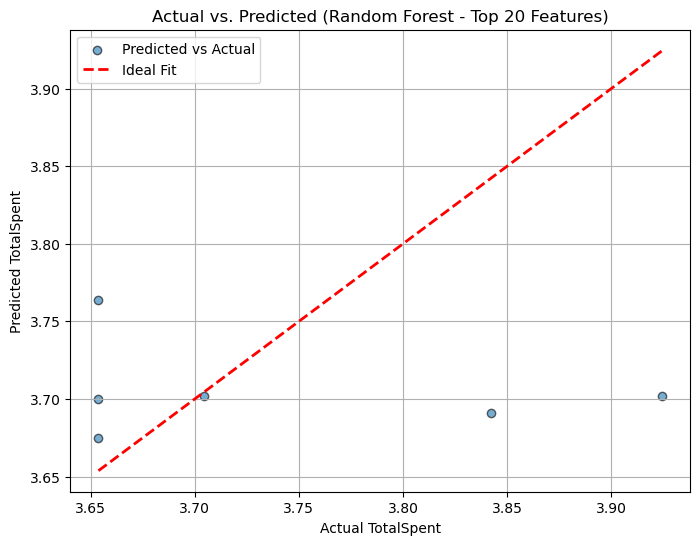

In [123]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.scatter(y_test_selected, y_pred_rf_selected, alpha=0.6, edgecolors='k', label='Predicted vs Actual')
plt.plot([y_test_selected.min(), y_test_selected.max()], 
         [y_test_selected.min(), y_test_selected.max()], 
         'r--', lw=2, label='Ideal Fit')

plt.title('Actual vs. Predicted (Random Forest - Top 20 Features)')
plt.xlabel('Actual TotalSpent')
plt.ylabel('Predicted TotalSpent')
plt.legend()
plt.grid(True)
plt.show()


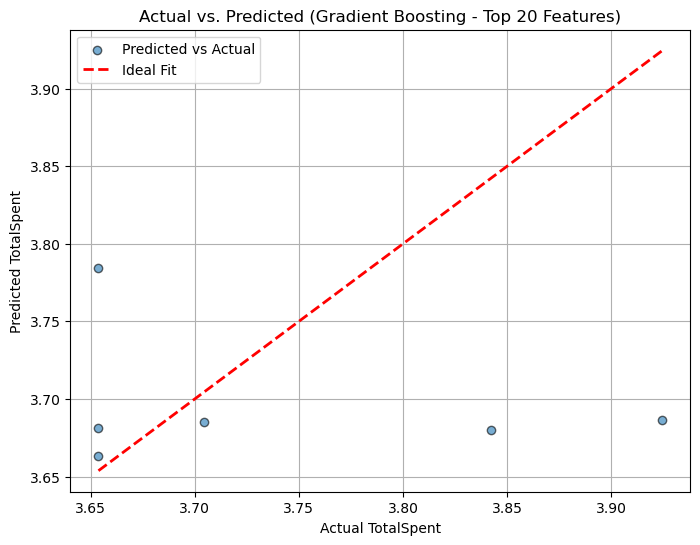

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_selected, y_pred_gb_selected, alpha=0.6, edgecolors='k', label='Predicted vs Actual')
plt.plot([y_test_selected.min(), y_test_selected.max()], 
         [y_test_selected.min(), y_test_selected.max()], 
         'r--', lw=2, label='Ideal Fit')

plt.title('Actual vs. Predicted (Gradient Boosting - Top 20 Features)')
plt.xlabel('Actual TotalSpent')
plt.ylabel('Predicted TotalSpent')
plt.legend()
plt.grid(True)
plt.show()


From the model evaluations above and the plots , Linear Regression achieved the lowest MSE and the only positive R² score, meaning it provides the best fit to the data among the three model. Both Random Forest and Gradient Boosting had negative R² scores, indicating that they performed worse than simply predicting the mean value for all observations.The negative R² values from tree-based models may suggest overfitting, insufficient data, or that these models are too complex for the selected features.

Based on the evaluation metrics: Linear Regression is the best performing model for predicting customer TotalSpent in this context.i will go ahead and save the best model.

In [125]:
import os
import joblib

# Create the 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

In [126]:
#save the scaler used for the selected features
import joblib

# Suppose your model is named 'model'
joblib.dump(lr_model_selected, 'chinook_predictive_model.pkl')

joblib.dump(scaler_selected, 'models/scaler_top_features.pkl')

# To load it later:

#lr_model = joblib.load('models/linear_regression_model.pkl')
#scaler = joblib.load('models/scaler_top_features.pkl')


['models/scaler_top_features.pkl']

**Conclusion **
Linear Regression is the best-performing model in this case, as it has the lowest prediction error (MSE) and the only positive R², indicating a better fit to the data.

The Random Forest and Gradient Boosting models, despite their complexity and ability to model nonlinearities, performed poorly on this dataset, possibly due to insufficient data, inappropriate hyperparameters, or overfitting.

So, the Linear Regression model for this prediction task, but the Random Forest and Gradient Boosting models might do well if there is enough data to improve their performance.
